# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [ ]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2021-09-09 13:19:11--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2021-09-09 13:19:11--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5deaa7342fe3c977037b52e2c5.dl.dropboxusercontent.com/cd/0/inline/BV1Xadxu3n1IXx9tmNqkzNsyPqTH-qiWf5Nfv32dKnJMwKD6OI69u7qmIKkNKhRIrc-9SGTT9iC0dN2VgIBK9tGL7I5hX4G3LAlD7QVGEomgnpPVlkLWcmcvEX1u3RkqKxwuHAbN9k67C60YDA3Gjv_H/file# [following]
--2021-09-09 13:19:11--  https://uc5deaa7342fe3c977037b52e2c5.dl.dropboxusercontent.com/cd/0/inline/BV1Xadxu3n1IXx9tmNqkzNsyPqTH-qiWf5Nfv32dKnJMwKD6OI69u7qmIKkNKhRIrc-9SGTT9iC0dN2VgIBK9tGL7I

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [5]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [27]:
from nltk import ngrams

In [10]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [11]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [12]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [13]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [19]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [20]:
list(vec.vocabulary_.items())[:10]

[('shikalovap', 77944),
 ('апхзаза', 101165),
 ('тоже', 222582),
 ('по', 183965),
 ('ним', 168559),
 ('фанючу', 230485),
 ('ну', 169726),
 ('конечно', 147470),
 ('же', 131313),
 ('шиперю', 239366)]

In [21]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

C:\Users\mad_i\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

In [22]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     28291
    positive       0.76      0.77      0.76     28418

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Попробуем сделать то же самое для триграмм:

In [23]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\mad_i\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

    negative       0.47      0.72      0.57     18171
    positive       0.82      0.61      0.70     38538

    accuracy                           0.65     56709
   macro avg       0.64      0.67      0.63     56709
weighted avg       0.71      0.65      0.66     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?) Наверное, потому, что три слова могут иметь совершенно разный характер и направленность, нежели одно которое проще классифицировать.

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.76      0.75     26803
    positive       0.78      0.75      0.76     29906

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [30]:
#import nltk
from nltk import collocations 
#nltk.download('genesis')

print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('***ТЫ', 'ЛАПОЧКА'), ('***ахах', 'Ксююю'), ('***сегодня', 'ироска'), ('*_____________*', 'ГОСПОДИБОЖЕ'), ('*__________________*', 'вообщеееееееее'), ('*blog', 'Трансформация'), ('*facepalm.jpg*', 'Ебанные'), ('*happy', 'tree*'), ('*linux', '*arch'), ('*Белый', 'плен*'), ('*ВЕЧНАЯ', 'ПАМЯТЬ*'), ('*Кукэева', 'минем**Лучшая'), ('*СЛЕЗЫ', 'СЛЕЗЫ*'), ('*Ургант*', '-Давайте'), ('*аалгах', 'гээх'), ('*белая', 'зависть*'), ('*возможную', 'дочь*-*прости'), ('*вот', 'зараза*'), ('*вспоминаю', 'евоные'), ('*вчера', 'перечитывал'), ('*вытирает', 'стекающий'), ('*гениальный', 'вопрос*'), ('*громко', 'смеется*'), ('*довольная', 'ангарская'), ('*здесь*-это', '*куда*'), ('*злобный', 'смех*'), ('*ирный', 'у*людок'), ('*истерический', 'ржач*'), ('*крепко', 'обнял*'), ('*ленивая', 'жопа*'), ('*лучи', 'отдыха*'), ('*мастер', 'отмазок*'), ('*мое', 'мнение*'), ('*нормальным', 'голосом*Лен'), ('*опустил', 'голову*'), ('*палец', 'вверх*'), ('*поймал',

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [31]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('у', 'нас'), ('(', ','), (':', ')'), (',', '('), ('не', 'могу'), (':', '-'), (',', ')'), ('?', '?'), (')', ','), (':', '*'), (',', ':'), ('@', '('), (',', ','), (':', ','), ('(', ':'), ('@', ')'), ('@', ','), ('&', 'lt'), ('со', 'мной'), ('@', ':'), ('(', '@'), (':', ':'), (';', ')'), ('новый', 'год'), ('gt', ';'), ('не', 'знаю'), (',', '@'), (')', ':'), ('@', '@'), ('а', 'я'), ('У', 'меня'), (',', 'когда'), ('сих', 'пор'), ('lt', ';'), ('потому', 'что'), ('&', 'gt'), ('у', 'тебя'), ('все', 'равно'), (';', '('), ('с', 'тобой'), (',', 'как'), ('в', 'школу'), (')', '@'), ('(', 'http'), ('ничего', 'не'), (',', 'я'), ('&', 'amp'), ('-', ')'), ('Доброе', 'утро'), ('Как', 'же'), (':', 'DD'), ('я', 'не'), ('не', '('), ('самом', 'деле'), ('--', '--'), ('D', 'http'), ('не', ')'), ('до', 'сих'), ('что', 'я'), ('amp', ';'), ('(', '!'), (','

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [32]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to C:\nltk_data...


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data]   Unzipping corpora\stopwords.zip.


In [33]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [39]:
vec = CountVectorizer(ngram_range=(1, 1), stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\mad_i\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

    negative       0.76      0.75      0.75     28253
    positive       0.75      0.76      0.76     28456

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [40]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
tar: Error opening archive: Failed to open 'mystem-3.0-linux3.1-64bit.tar.gz'
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [42]:
pip install pymystem3

Note: you may need to restart the kernel to use updated packages.


In [43]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Installing mystem to C:\Users\mad_i/.local/bin\mystem.exe from http://download.cdn.yandex.net/mystem/mystem-3.1-win-64bit.zip


Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [44]:
print(mystem_analyzer.lemmatize(example))

NameError: name 'example' is not defined

А можно получить грамматическую информацию:

In [ ]:
mystem_analyzer.analyze(example)

[{'analysis': [{'gr': 'CONJ=', 'lex': 'но', 'wt': 0.9998906255}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'gr': 'PART=', 'lex': 'не', 'wt': 1}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)',
    'lex': 'каждый',
    'wt': 0.9985975623}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=непрош,ед,изъяв,3-л',
    'lex': 'хотеть',
    'wt': 1}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'gr': 'SPRO,ед,сред,неод=(вин|им)', 'lex': 'что-то', 'wt': 1}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,пе=инф,несов', 'lex': 'исправлять', 'wt': 1}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [45]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [46]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

KeyboardInterrupt: 

### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [47]:
!pip install pymorphy2

In [48]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [49]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [50]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [51]:
!pip install razdel

In [52]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [53]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [54]:
!pip install natasha

С помощью библиотеки natasha можно также лемматизировать тексты.

In [55]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [56]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'Посол': 'посол',
 'Израиля': 'израиль',
 'на': 'на',
 'Украине': 'украина',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'признался': 'признаться',
 ',': ',',
 'что': 'что',
 'пришел': 'прийти',
 'в': 'в',
 'шок': 'шок',
 'узнав': 'узнать',
 'о': 'о',
 'решении': 'решение',
 'властей': 'власть',
 'Львовской': 'львовский',
 'области': 'область',
 'объявить': 'объявить',
 '2019': '2019',
 'год': 'год',
 'годом': 'год',
 'лидера': 'лидер',
 'запрещенной': 'запретить',
 'России': 'россия',
 'Организации': 'организация',
 'украинских': 'украинский',
 'националистов': 'националист',
 '(': '(',
 'ОУН': 'оун',
 ')': ')',
 'Степана': 'степан',
 'Бандеры': 'бандера',
 '.': '.',
 'Свое': 'свой',
 'заявление': 'заявление',
 'он': 'он',
 'разместил': 'разместить',
 'Twitter': 'twitter',
 '«': '«',
 'Я': 'я',
 'не': 'не',
 'могу': 'мочь',
 'понять': 'понять',
 'как': 'как',
 'прославление': 'прославление',
 'тех': 'тот',
 'кто': 'кто',
 'непосредственно': 'непосредственно',
 'принимал': 'принимать',
 'уча

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [57]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [58]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [59]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [60]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [61]:
from collections import Counter

In [63]:
corpus = [token for tweet in df.text for token in tweet if token not in punctuation]
print(len(corpus))
corpus[:10]

16835065


['f', 'i', 'r', 's', 't', 't', 'i', 'm', 'e', 'e']

In [64]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[(' ', 2534243),
 ('о', 1202363),
 ('а', 1045264),
 ('е', 970724),
 ('т', 769382),
 ('н', 725179),
 ('и', 672003),
 ('с', 552691),
 ('л', 466517),
 ('р', 452949)]

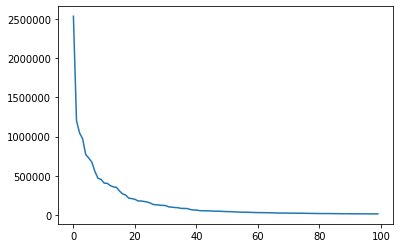

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [67]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokeniz)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.76      0.75     26803
    positive       0.78      0.75      0.76     29906

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [69]:
cool_token = 
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

SyntaxError: invalid syntax (<ipython-input-69-42a0fb38ba5c>, line 1)

## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.99      1.00      1.00     27667
   positive       1.00      0.99      1.00     29042

avg / total       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## Домашнее задание

### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

Создайте мешок слов с помощью
sklearn.feature_extraction.text.CountVectorizer.fit_transform(). Применим его к 'tweet_stemmed'
и 'tweet_lemmatized' отдельно.
● Игнорируем слова, частота которых в документе строго превышает порог 0.9 с
помощью max_df.
● Ограничим количество слов, попадающий в мешок, с помощью max_features =
1000.
● Исключим стоп-слова с помощью stop_words='english'.
● Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с
помощью CountVectorizer.get_feature_names().


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их

Создайте мешок слов с помощью
sklearn.feature_extraction.text.TfidfVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и
'tweet_lemmatized' отдельно.
● Игнорируем слова, частота которых в документе строго превышает порог 0.9 с
помощью max_df.
● Ограничим количество слов, попадающий в мешок, с помощью max_features =
1000.
● Исключим стоп-слова с помощью stop_words='english'.
● Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с
помощью TfidfVectorizer.get_feature_names().


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

Проверьте ваши векторайзеры на корпусе который использовали на вебинаре, составьте
таблицу метод векторизации и скор который вы получили (в методах векторизации по
изменяйте параметры что бы добиться лучшего скора) обратите внимание как
падает/растёт скор при уменьшении количества фичей, и изменении параметров, так же
попробуйте применить к векторайзерам PCA для сокращения размерности посмотрите на
качество сделайте выводы

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [4]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

In [5]:
def compare_stemmer(sentence):
    word_list = word_tokenize(sentence)
    snow_stemmer = SnowballStemmer(language='russian')
    stemmer_output = ' '.join([snow_stemmer.stem(w) for w in word_list])
    return stemmer_output

def compare_lemmatizer(sentence):
    word_list = word_tokenize(sentence)
    # Lemmatize list of words and join
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [6]:
stemmer = PorterStemmer()
df['tweet_stemmed'] = np.vectorize(compare_stemmer)(df.text)

In [7]:
lemmatizer = WordNetLemmatizer()

df['tweet_lemmatized'] = np.vectorize(compare_lemmatizer)(df.text)

In [8]:
df

,text,label,tweet_stemmed,tweet_lemmatized
0,"@first_timee хоть я и школота, но поверь, у на...",positive,"@ first_timee хот я и школот , но повер , у на...","@ first_timee хоть я и школота , но поверь , у..."
1,"Да, все-таки он немного похож на него. Но мой ...",positive,"да , все-так он немн похож на нег . но мо маль...","Да , все-таки он немного похож на него . Но мо..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive,RT @ KatiaCheh : ну ты идиотк ) я испуга за те...,RT @ KatiaCheh : Ну ты идиотка ) я испугалась ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive,RT @ digger2912 : `` кто то в угл сид и погиба...,RT @ digger2912 : `` Кто то в углу сидит и пог...
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive,@ irina_dyshkant вот что знач страшилк : D но ...,@ irina_dyshkant Вот что значит страшилка : D ...
...,...,...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,negative,но не кажд хочет что то исправля : ( http : //...,Но не каждый хочет что то исправлять : ( http ...
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative,скуча так : - ( тольк @ taaannyaaa вправля моз...,скучаю так : - ( только @ taaannyaaa вправляет...
111920,"Вот и в школу, в говно это идти уже надо(",negative,"вот и в школ , в говн эт идт уж над (","Вот и в школу , в говно это идти уже надо ("
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative,"RT @ _Them__ : @ LisaBeroud тауриэл , не груст...","RT @ _Them__ : @ LisaBeroud Тауриэль , не грус..."


In [9]:
x_train_stemmed, x_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(df.tweet_stemmed, df.label)

In [10]:
x_train_lemmatized, x_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(df.tweet_lemmatized, df.label)

In [11]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vec_stemmed = CountVectorizer(ngram_range=(1, 1), max_df=0.9, max_features=1000, stop_words='english')
bow_stemmed = vec_stemmed.fit_transform(x_train_stemmed) # bow -- bag of words (мешок слов)

In [24]:
list(vec_stemmed.vocabulary_.items())[:10]

[('сейчас', 752),
 ('мен', 410),
 ('эт', 994),
 ('держ', 203),
 ('больш', 63),
 ('люд', 400),
 ('чем', 966),
 ('том', 879),
 ('год', 163),
 ('на', 446)]

In [28]:
vec_stemmed.get_feature_names()

['00',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '20',
 '30',
 '40',
 '50',
 '99',
 'amp',
 'cо',
 'dd',
 'ddd',
 'follow',
 'gt',
 'http',
 'https',
 'lt',
 'o_o',
 'rt',
 'tukvasociopat',
 'аа',
 'ааа',
 'аааа',
 'автобус',
 'аг',
 'ад',
 'аж',
 'айфон',
 'ал',
 'алгебр',
 'ан',
 'английск',
 'ах',
 'ахах',
 'ахахах',
 'баб',
 'бабушк',
 'бега',
 'бедн',
 'без',
 'безумн',
 'бел',
 'бес',
 'билет',
 'бл',
 'близк',
 'блин',
 'бля',
 'блят',
 'бо',
 'бог',
 'бож',
 'бол',
 'болет',
 'больн',
 'больниц',
 'больш',
 'брат',
 'брос',
 'буд',
 'будет',
 'будеш',
 'будт',
 'будут',
 'будущ',
 'бы',
 'быва',
 'был',
 'быстр',
 'быт',
 'важн',
 'вам',
 'ван',
 'вариант',
 'вас',
 'ваш',
 'ващ',
 'вдруг',
 'ве',
 'вед',
 'везд',
 'велик',
 'вер',
 'верн',
 'вернул',
 'вернут',
 'весел',
 'весн',
 'вечер',
 'вечн',
 'вещ',
 'взял',
 'взят',
 'вид',
 'виде',
 'видел',
 'видет',
 'видим',
 'видн',
 'виж',
 'виноват',
 'вк',
 'включ',
 'вкусн',
 'вмест',
 'во',
 'вод',
 'во

In [25]:
clf_stemmed = LogisticRegression(random_state=42)
clf_stemmed.fit(bow_stemmed, y_train_stemmed)

C:\Users\mad_i\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

In [26]:
pred_stemmed = clf_stemmed.predict(vec_stemmed.transform(x_test_stemmed))
print(classification_report(pred_stemmed, y_test_stemmed))

              precision    recall  f1-score   support

    negative       0.69      0.71      0.70     27137
    positive       0.72      0.70      0.71     29572

    accuracy                           0.70     56709
   macro avg       0.70      0.70      0.70     56709
weighted avg       0.71      0.70      0.70     56709



In [18]:
vec_lemmatized = CountVectorizer(ngram_range=(1, 1), max_df=0.9, max_features=1000, stop_words='english')
bow_lemmatized = vec_lemmatized.fit_transform(x_train_lemmatized) # bow -- bag of words (мешок слов)

In [19]:
list(vec_lemmatized.vocabulary_.items())[:10]

[('хороший', 935),
 ('но', 518),
 ('не', 486),
 ('лучший', 379),
 ('был', 76),
 ('таким', 838),
 ('на', 449),
 ('дня', 207),
 ('потом', 652),
 ('rt', 30)]

In [27]:
vec_lemmatized.get_feature_names()

['00',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '20',
 '2013',
 '2014',
 '21',
 '30',
 '33',
 '40',
 '50',
 '99',
 'amp',
 'cio_optimal',
 'dd',
 'ddd',
 'follow',
 'gt',
 'http',
 'lt',
 'mtvstars',
 'o_o',
 'rt',
 'teamfollowback',
 'tukvasociopat',
 'ааа',
 'аааа',
 'ааааа',
 'ага',
 'аж',
 'английский',
 'ах',
 'ахах',
 'ахаха',
 'ахахах',
 'ахахаха',
 'ахахахах',
 'бабушка',
 'без',
 'безумно',
 'бесит',
 'бл',
 'блиин',
 'блин',
 'бля',
 'блять',
 'боже',
 'более',
 'болеть',
 'болею',
 'болит',
 'боль',
 'больницу',
 'больно',
 'больше',
 'большое',
 'большой',
 'боюсь',
 'брат',
 'будем',
 'будет',
 'будешь',
 'будто',
 'буду',
 'будут',
 'будь',
 'бы',
 'бывает',
 'был',
 'была',
 'были',
 'было',
 'быстрее',
 'быстро',
 'быть',
 'вам',
 'вами',
 'вас',
 'ваще',
 'вдруг',
 'ведь',
 'везде',
 'верю',
 'весело',
 'весь',
 'вечер',
 'вечера',
 'вечером',
 'вечно',
 'вещи',
 'взять',
 'видел',
 'видела',
 'видео',
 'видеть',
 'видимо',
 'видно',
 'ви

In [21]:
clf_lemmatized = LogisticRegression(random_state=42)
clf_lemmatized.fit(bow_lemmatized, y_train_lemmatized)

C:\Users\mad_i\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

In [22]:
pred_lemmatized = clf_lemmatized.predict(vec_lemmatized.transform(x_test_lemmatized))
print(classification_report(pred_lemmatized, y_test_lemmatized))

              precision    recall  f1-score   support

    negative       0.66      0.71      0.69     26376
    positive       0.73      0.69      0.71     30333

    accuracy                           0.70     56709
   macro avg       0.70      0.70      0.70     56709
weighted avg       0.70      0.70      0.70     56709



In [30]:
vectorizer_stemmed = TfidfVectorizer(ngram_range=(1, 1), max_df=0.9, max_features=1000, stop_words='english')
bow_stemmed = vectorizer_stemmed.fit_transform(x_train_stemmed)

In [31]:
list(vectorizer_stemmed.vocabulary_.items())[:10]

[('сейчас', 752),
 ('мен', 410),
 ('эт', 994),
 ('держ', 203),
 ('больш', 63),
 ('люд', 400),
 ('чем', 966),
 ('том', 879),
 ('год', 163),
 ('на', 446)]

In [32]:
vec_stemmed.get_feature_names()

['00',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '20',
 '30',
 '40',
 '50',
 '99',
 'amp',
 'cо',
 'dd',
 'ddd',
 'follow',
 'gt',
 'http',
 'https',
 'lt',
 'o_o',
 'rt',
 'tukvasociopat',
 'аа',
 'ааа',
 'аааа',
 'автобус',
 'аг',
 'ад',
 'аж',
 'айфон',
 'ал',
 'алгебр',
 'ан',
 'английск',
 'ах',
 'ахах',
 'ахахах',
 'баб',
 'бабушк',
 'бега',
 'бедн',
 'без',
 'безумн',
 'бел',
 'бес',
 'билет',
 'бл',
 'близк',
 'блин',
 'бля',
 'блят',
 'бо',
 'бог',
 'бож',
 'бол',
 'болет',
 'больн',
 'больниц',
 'больш',
 'брат',
 'брос',
 'буд',
 'будет',
 'будеш',
 'будт',
 'будут',
 'будущ',
 'бы',
 'быва',
 'был',
 'быстр',
 'быт',
 'важн',
 'вам',
 'ван',
 'вариант',
 'вас',
 'ваш',
 'ващ',
 'вдруг',
 'ве',
 'вед',
 'везд',
 'велик',
 'вер',
 'верн',
 'вернул',
 'вернут',
 'весел',
 'весн',
 'вечер',
 'вечн',
 'вещ',
 'взял',
 'взят',
 'вид',
 'виде',
 'видел',
 'видет',
 'видим',
 'видн',
 'виж',
 'виноват',
 'вк',
 'включ',
 'вкусн',
 'вмест',
 'во',
 'вод',
 'во

In [33]:
clf_stemmed = LogisticRegression(random_state=42)
clf_stemmed.fit(bow_stemmed, y_train_stemmed)

LogisticRegression(random_state=42)

In [34]:
pred_stemmed = clf_stemmed.predict(vec_stemmed.transform(x_test_stemmed))
print(classification_report(pred_stemmed, y_test_stemmed))

              precision    recall  f1-score   support

    negative       0.69      0.70      0.69     27311
    positive       0.72      0.70      0.71     29398

    accuracy                           0.70     56709
   macro avg       0.70      0.70      0.70     56709
weighted avg       0.70      0.70      0.70     56709



In [35]:
vectorizer_lemmatized = TfidfVectorizer(ngram_range=(1, 1), max_df=0.9, max_features=1000, stop_words='english')
bow_lemmatized = vectorizer_lemmatized.fit_transform(x_train_lemmatized)

In [36]:
list(vectorizer_lemmatized.vocabulary_.items())[:10]

[('хороший', 935),
 ('но', 518),
 ('не', 486),
 ('лучший', 379),
 ('был', 76),
 ('таким', 838),
 ('на', 449),
 ('дня', 207),
 ('потом', 652),
 ('rt', 30)]

In [37]:
vec_lemmatized.get_feature_names()

['00',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '20',
 '2013',
 '2014',
 '21',
 '30',
 '33',
 '40',
 '50',
 '99',
 'amp',
 'cio_optimal',
 'dd',
 'ddd',
 'follow',
 'gt',
 'http',
 'lt',
 'mtvstars',
 'o_o',
 'rt',
 'teamfollowback',
 'tukvasociopat',
 'ааа',
 'аааа',
 'ааааа',
 'ага',
 'аж',
 'английский',
 'ах',
 'ахах',
 'ахаха',
 'ахахах',
 'ахахаха',
 'ахахахах',
 'бабушка',
 'без',
 'безумно',
 'бесит',
 'бл',
 'блиин',
 'блин',
 'бля',
 'блять',
 'боже',
 'более',
 'болеть',
 'болею',
 'болит',
 'боль',
 'больницу',
 'больно',
 'больше',
 'большое',
 'большой',
 'боюсь',
 'брат',
 'будем',
 'будет',
 'будешь',
 'будто',
 'буду',
 'будут',
 'будь',
 'бы',
 'бывает',
 'был',
 'была',
 'были',
 'было',
 'быстрее',
 'быстро',
 'быть',
 'вам',
 'вами',
 'вас',
 'ваще',
 'вдруг',
 'ведь',
 'везде',
 'верю',
 'весело',
 'весь',
 'вечер',
 'вечера',
 'вечером',
 'вечно',
 'вещи',
 'взять',
 'видел',
 'видела',
 'видео',
 'видеть',
 'видимо',
 'видно',
 'ви

In [38]:
clf_lemmatized = LogisticRegression(random_state=42)
clf_lemmatized.fit(bow_lemmatized, y_train_lemmatized)

LogisticRegression(random_state=42)

In [39]:
pred_lemmatized = clf_lemmatized.predict(vec_lemmatized.transform(x_test_lemmatized))
print(classification_report(pred_lemmatized, y_test_lemmatized))

              precision    recall  f1-score   support

    negative       0.70      0.69      0.69     28481
    positive       0.69      0.70      0.69     28228

    accuracy                           0.69     56709
   macro avg       0.69      0.69      0.69     56709
weighted avg       0.69      0.69      0.69     56709

